# **Data Retrieval From ChEMBL Database**
My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TechOpenCADD project of Volkamer Lab. With some minor modifications, I tried to made it available for the students working with a Biology background. For Proper understanding and learning, you can follow the video tutorial on **Bioinformatics Insights** https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

This notebook is majorly designed for teaching purposes.

For citation and reading, https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x


**Learning and Training Objectives**
1. Retrieving compound data and activities from ChEMBL for a protein (receptor) of your choice.
**Understanding units**

**1. IC50** is a standared unit used in biochemical assays for inhibition. It stands for Inhibitory concentration at 50 or Half maximal inhibitory concentration. The lower value indicates higher potency of a drug. You may also see **pIC50**, that is = -log10(IC50). It makes the opposite of IC50, meaning higher pIC50 means higher potency of a drug.

Let's begin,


##Pre-requisite Installation and Imports

In [1]:
! pip install chembl_webresource_client
! pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 28.4 MB/s eta 0:00:00


In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Creating some API tokens for target

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In this tutorial we will use **Epidermal Growth Factor (EGFR)** protein, which is a kinase by nature. We will fetch them from Uniprot Accession ID.

In [6]:
uniprot_id = "P00533"

In [ ]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [ ]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION
9,Homo sapiens,CCN2-EGFR,CHEMBL5465557,PROTEIN-PROTEIN INTERACTION


Below we will select the exact ChEMBL data via index options

In [ ]:
target = targets.iloc[0]
target

,0
organism,Homo sapiens
pref_name,Epidermal growth factor receptor erbB1
target_chembl_id,CHEMBL203
target_type,SINGLE PROTEIN


In [ ]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL203


Below we are going to fetch some important variable of the data for ourself. You can change them if you want to extract some other column.

In [ ]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 17273, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [ ]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

Download the dataset

In [ ]:
#Downloading Data
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (11634, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50,uM,3000.0


In [7]:
import pandas as pd
import requests

# File name
input_file = "Part1_Pharmacophore_Modeling_EGFR_Compounds.xlsx"

# Step 1: Read the Excel file and extract ChEMBL IDs
compounds_df = pd.read_excel(input_file)
if 'chembl_id' not in compounds_df.columns:
    raise KeyError("The file must have a column named 'chembl_id'.")

chembl_ids = compounds_df['chembl_id'].dropna().unique()

# Step 2: Function to fetch bioactivity data from the ChEMBL database
def fetch_bioactivities(chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/activity.json?molecule_chembl_id={chembl_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'activities' in data:  # Check if activities are present
            return pd.DataFrame(data['activities'])
        else:
            return pd.DataFrame()  # Return empty DataFrame if no activities
    else:
        print(f"Error fetching data for {chembl_id}: {response.status_code}")
        return pd.DataFrame()

# Step 3: Fetch bioactivities for each ChEMBL ID and combine into a single DataFrame
bioactivities_list = []
for chembl_id in chembl_ids:
    print(f"Fetching bioactivities for {chembl_id}...")
    bioactivities = fetch_bioactivities(chembl_id)
    if not bioactivities.empty:
        bioactivities_list.append(bioactivities)

# Combine all bioactivities into a single DataFrame
bioactivities_df = pd.concat(bioactivities_list, ignore_index=True)

# Step 4: Display or save the results
print("Bioactivities data collected:")
print(bioactivities_df.head())

output_file = "bioactivities_data.csv"
bioactivities_df.to_csv(output_file, index=False)
print(f"Bioactivities data has been saved to {output_file}.")


Fetching bioactivities for CHEMBL113901...
Fetching bioactivities for CHEMBL113996...
Fetching bioactivities for CHEMBL114073...
Fetching bioactivities for CHEMBL114490...
Fetching bioactivities for CHEMBL1173655...
Fetching bioactivities for CHEMBL1243254...
Fetching bioactivities for CHEMBL1243255...
Fetching bioactivities for CHEMBL1243283...
Fetching bioactivities for CHEMBL1243284...
Fetching bioactivities for CHEMBL1243345...
Fetching bioactivities for CHEMBL1243346...
Fetching bioactivities for CHEMBL175552...
Fetching bioactivities for CHEMBL175933...
Fetching bioactivities for CHEMBL179572...
Fetching bioactivities for CHEMBL180175...
Fetching bioactivities for CHEMBL2031307...
Fetching bioactivities for CHEMBL2105712...
Fetching bioactivities for CHEMBL2135461...
Fetching bioactivities for CHEMBL3092315...
Fetching bioactivities for CHEMBL3545154...
Fetching bioactivities for CHEMBL3622661...
Fetching bioactivities for CHEMBL3622663...
Fetching bioactivities for CHEMBL367492.

<ipython-input-7-f047a8588411>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bioactivities_df = pd.concat(bioactivities_list, ignore_index=True)


Bioactivities data collected:
  action_type activity_comment  activity_id activity_properties  \
0        None             None       368906                  []   
1        None             None       368907                  []   
2        None             None       368908                  []   
3        None             None       368909                  []   
4        None             None       368910                  []   

  assay_chembl_id                                  assay_description  \
0    CHEMBL680028  Inhibition of autophosphorylation of cytoplasm...   
1    CHEMBL769139  Concentration required to inhibit autophosphor...   
2    CHEMBL620834  Concentration required to inhibit growth of hu...   
3    CHEMBL806367  Concentration required to inhibit growth of hu...   
4    CHEMBL805740  Concentration required to inhibit growth of hu...   

  assay_type assay_variant_accession assay_variant_mutation bao_endpoint  ...  \
0          B                    None                 

In [23]:
bioactivities_df = pd.read_csv("bioactivities_data.csv")

In [25]:
import pandas as pd

# Assuming bioactivities_df already exists
# Columns to keep
columns_to_keep = [
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
]

# Keep only the specified columns
bioactivities_df = bioactivities_df[columns_to_keep]

# Display the first few rows of the updated DataFrame
print("Filtered bioactivities_df:")
print(bioactivities_df.head())

Filtered bioactivities_df:
   activity_id assay_chembl_id  \
0       368906    CHEMBL680028   
1       368907    CHEMBL769139   
2       368908    CHEMBL620834   
3       368909    CHEMBL806367   
4       368910    CHEMBL805740   

                                   assay_description assay_type  \
0  Inhibition of autophosphorylation of cytoplasm...          B   
1  Concentration required to inhibit autophosphor...          B   
2  Concentration required to inhibit growth of hu...          F   
3  Concentration required to inhibit growth of hu...          F   
4  Concentration required to inhibit growth of hu...          F   

  molecule_chembl_id  type standard_units relation  standard_value  \
0       CHEMBL113901  IC50             nM        =          5220.0   
1       CHEMBL113901  IC50             nM        =         11820.0   
2       CHEMBL113901  IC50             nM        =           430.0   
3       CHEMBL113901  IC50             nM        =           190.0   
4       CHEMBL1

In [28]:
import pandas as pd

# Assuming bioactivities_df already exists
# Filter rows where 'assay_type' is 'B'
bioactivities_df = bioactivities_df[bioactivities_df['assay_type'] == 'B']

# Display the first few rows of the updated DataFrame
print("Filtered bioactivities_df with assay_type = 'B':")
print(bioactivities_df.head())

Filtered bioactivities_df with assay_type = 'B':
   activity_id assay_chembl_id  \
0       368906    CHEMBL680028   
1       368907    CHEMBL769139   
6      6261380   CHEMBL1798351   
7     12464844   CHEMBL3056386   
8       346388    CHEMBL680028   

                                   assay_description assay_type  \
0  Inhibition of autophosphorylation of cytoplasm...          B   
1  Concentration required to inhibit autophosphor...          B   
6  Inhibition autophosphorylation of EGFR in huma...          B   
7                Inhibition of EGFR (unknown origin)          B   
8  Inhibition of autophosphorylation of cytoplasm...          B   

  molecule_chembl_id   type standard_units relation  standard_value  \
0       CHEMBL113901   IC50             nM        =         5220.00   
1       CHEMBL113901   IC50             nM        =        11820.00   
6       CHEMBL113901  pIC50             nM        =         5248.07   
7       CHEMBL113901  pIC50             nM        =      52

In [29]:
bioactivities_df.head(10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,standard_units,relation,standard_value,target_chembl_id,target_organism
0,368906,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113901,IC50,nM,=,5220.00,CHEMBL203,Homo sapiens
1,368907,CHEMBL769139,Concentration required to inhibit autophosphor...,B,CHEMBL113901,IC50,nM,=,11820.00,CHEMBL1824,Homo sapiens
6,6261380,CHEMBL1798351,Inhibition autophosphorylation of EGFR in huma...,B,CHEMBL113901,pIC50,nM,=,5248.07,CHEMBL203,Homo sapiens
7,12464844,CHEMBL3056386,Inhibition of EGFR (unknown origin),B,CHEMBL113901,pIC50,nM,=,5220354.55,CHEMBL203,Homo sapiens
8,346388,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113996,IC50,nM,=,13570.00,CHEMBL203,Homo sapiens
9,346389,CHEMBL769139,Concentration required to inhibit autophosphor...,B,CHEMBL113996,IC50,nM,=,31430.00,CHEMBL1824,Homo sapiens
14,6261378,CHEMBL1798351,Inhibition autophosphorylation of EGFR in huma...,B,CHEMBL113996,pIC50,nM,=,13489.63,CHEMBL203,Homo sapiens
15,12464846,CHEMBL3056386,Inhibition of EGFR (unknown origin),B,CHEMBL113996,pIC50,nM,=,13567505.30,CHEMBL203,Homo sapiens
16,377315,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL114073,IC50,nM,=,10590.00,CHEMBL203,Homo sapiens
17,377316,CHEMBL769139,Concentration required to inhibit autophosphor...,B,CHEMBL114073,IC50,nM,=,33950.00,CHEMBL1824,Homo sapiens


It is possible that some of the rows show redundant data, but do not worry we will remove that later

**Now we want to know how many different units are present in the data**

In [30]:
bioactivities_df["units"].unique()

KeyError: 'units'

Below we will do some tweaking with units to make them uniform

In [31]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

KeyError: "['units', 'value'] not found in axis"

**Data Processing and Filteration**

Delete entries with missing and duplicate values.

Reset index number and rename columns.



In [32]:
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
type,object
standard_units,object
relation,object
standard_value,float64
target_chembl_id,object


In [34]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
type,object
standard_units,object
relation,object
standard_value,float64
target_chembl_id,object


In [35]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (621, 11)


In [36]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' '%' 'hr' 'M-1 s-1' 'uM' 'ug ml-1' 'fM (mg of protein)-1' 'M-1'
 'umol/min/mg' '/uM/min' 'U/mg' 'kDa']
Number of non-nM entries:    113


In [37]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [38]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (508, 11)


In [39]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (273, 11)


In [40]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,standard_units,relation,standard_value,target_chembl_id,target_organism
0,368906,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113901,IC50,nM,=,5220.0,CHEMBL203,Homo sapiens
1,346388,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113996,IC50,nM,=,13570.0,CHEMBL203,Homo sapiens
2,377315,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL114073,IC50,nM,=,10590.0,CHEMBL203,Homo sapiens
3,383110,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL114490,IC50,nM,=,2320.0,CHEMBL203,Homo sapiens
4,2246122,CHEMBL1009318,Inhibition of EGFR by HTRF assay,B,CHEMBL1173655,IC50,nM,=,6.0,CHEMBL203,Homo sapiens


In [41]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,units,relation,IC50,target_chembl_id,target_organism
0,368906,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113901,IC50,nM,=,5220.0,CHEMBL203,Homo sapiens
1,346388,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL113996,IC50,nM,=,13570.0,CHEMBL203,Homo sapiens
2,377315,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL114073,IC50,nM,=,10590.0,CHEMBL203,Homo sapiens
3,383110,CHEMBL680028,Inhibition of autophosphorylation of cytoplasm...,B,CHEMBL114490,IC50,nM,=,2320.0,CHEMBL203,Homo sapiens
4,2246122,CHEMBL1009318,Inhibition of EGFR by HTRF assay,B,CHEMBL1173655,IC50,nM,=,6.0,CHEMBL203,Homo sapiens


In [42]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (273, 11)


**Fetch compound data from ChEMBL**

Let’s have a look at the compounds from ChEMBL which we have defined so far. bioactivity data for: We are going to fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [43]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

**Download Compounds**

In [44]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/273 [00:00<?, ?it/s]

In [45]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (273, 2)


In [46]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL273387,{'canonical_smiles': 'CC[C@H]1OC(=O)[C@H](C)[C...
1,CHEMBL12282,{'canonical_smiles': 'CC[C@H]1OC(=O)[C@H](C)[C...
2,CHEMBL19667,{'canonical_smiles': 'CC(C)C[C@H](NC(=O)[C@H](...
3,CHEMBL411804,{'canonical_smiles': 'CC(C)[C@H](NC(=O)[C@H](C...
4,CHEMBL279444,{'canonical_smiles': 'COc1ccc(CN[C@@H](C(=O)N[...


In [47]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (273, 2)


In [48]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (273, 2)


In [49]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [50]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (273, 2)


In [51]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (273, 2)


**Let's output compound bioactivity data**

In [52]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 273


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'type', 'units', 'relation', 'IC50',
       'target_chembl_id', 'target_organism'],
      dtype='object')

In [53]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 273


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**Lets merge both the datasets**

Merge to contain, molecule ID, IC50, Units, and canonical smiles

In [54]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 273 entries.


In [55]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [56]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL113901,5220.00,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...
1,CHEMBL113996,13570.00,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...
2,CHEMBL114073,10590.00,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...
3,CHEMBL114490,2320.00,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...
4,CHEMBL1173655,6.00,nM,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...
5,CHEMBL1243254,0.57,nM,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...
6,CHEMBL1243255,5.35,nM,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...
7,CHEMBL1243283,1.81,nM,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...
8,CHEMBL1243284,8.12,nM,CNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cn...
9,CHEMBL1243345,0.80,nM,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...


**Convert IC50 values into pIC50 and put it in an extra column**

In [57]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [58]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [59]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL113901,5220.0,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...,5.282329
1,CHEMBL113996,13570.0,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...,4.867420
2,CHEMBL114073,10590.0,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...,4.975104
3,CHEMBL114490,2320.0,nM,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/...,5.634512
4,CHEMBL1173655,6.0,nM,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...,8.221849


**Distribution Based on IpIC50**

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

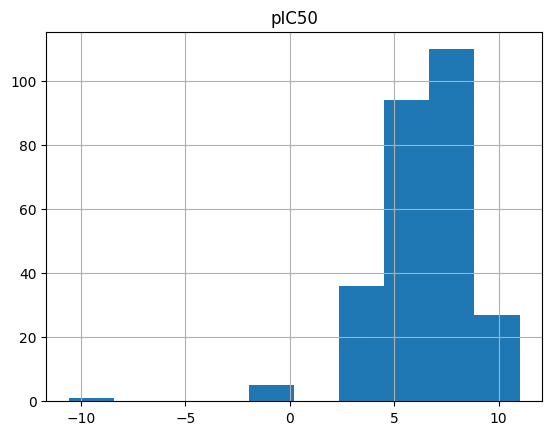

In [60]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [61]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

Failed to patch pandas - unable to change molecule rendering


In [62]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [63]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL3926441,0.010,nM,11.000000,<rdkit.Chem.rdchem.Mol object at 0x7b601f85a3b0>
1,CHEMBL4207145,0.012,nM,10.920819,<rdkit.Chem.rdchem.Mol object at 0x7b601f85b220>
2,CHEMBL571882,0.012,nM,10.920819,<rdkit.Chem.rdchem.Mol object at 0x7b601f850d60>


In [64]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (273, 5)


**Save Dataset for Next Session**

In [65]:
output_df.to_csv("/content/sample_data/Part1_Pharmacophore_with_Bioactivity.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL3926441,0.010,nM,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4cnc(OC...,11.000000
1,CHEMBL4207145,0.012,nM,CC(C)CN(C[C@@H](O)[C@H](Cc1cc(F)cc(F)c1)NC(=O)...,10.920819
2,CHEMBL571882,0.012,nM,COc1ccc2c(c1)OCC/C=C\CCCCN(C[C@@H](O)[C@H](Cc1...,10.920819
3,CHEMBL3907059,0.016,nM,CN1CCC(F)(COc2ncc(S(=O)(=O)NC(=O)c3ccc(N4CCN(C...,10.795880
4,CHEMBL3706613,0.040,nM,CC(C)(c1ncc(-c2cccnc2)o1)N1CCN(C[C@@H](O)C[C@@...,10.397940


In [66]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (273, 5)


##**Congratulation! You have started learning something new**

If you happy for your time, Please provide your Support in the Form of a Subscription on Youtube Channel**

[**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

Follow [**WhatsApp Channel**](https://whatsapp.com/channel/0029VajkwkdCHDydS6Y2lM36) for further updates, research services, and courses.